<h1 style='text-align:center'>Travel Insurance Claim Status Prediction</h1>
<h3 style='text-align:left'>Students Name: Maryam Baizhigitova, Moldir Kumarbek, Aiym Yermakhan </h3>

Following are the features of the dataset: (62288 rows × 12 columns)

- **Target:** Claim Status (Claim) 
- Name of agency (Agency) 
- Type of travel insurance agencies (Agency.Type) 
- Distribution channel of travel insurance agencies (Distribution.Channel) 
- Name of the travel insurance products (Product.Name) 
- Duration of travel (Duration) 
- Destination of travel (Destination) 
- Amount of sales of travel insurance policies (Net.Sales) 
- The commission received for travel insurance agency (Commission) 
- Gender of insured (Gender) 
- Age of insured (Age)
- ID

In [1]:
#import libraries
import pandas as pd
import numpy as np

#importing liabraries for graphical representation
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline

#Packages for feature engineering
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE

In [2]:
data = pd.read_csv('dataset.csv', low_memory=False)
print(data.columns)

Index(['ID', 'Age', 'Agency', 'Agency Type', 'Commision (in value)',
       'Destination', 'Distribution Channel', 'Duration', 'Gender',
       'Net Sales', 'Product Name', 'Claim'],
      dtype='object')


In [3]:
pd.set_option('display.max_columns', len(data.columns)) #To view all columns
pd.set_option('display.max_rows', 100)
data

,ID,Age,Agency,Agency Type,Commision (in value),Destination,Distribution Channel,Duration,Gender,Net Sales,Product Name,Claim
0,45341,28,C2B,Airlines,28.13,SINGAPORE,Online,34,F,112.5,Silver Plan,1
1,12958,37,JZI,Airlines,12.95,PHILIPPINES,Online,53,F,37.0,Basic Plan,0
2,18233,27,EPX,Travel Agency,0.00,UNITED STATES,Online,28,NaN,13.0,Cancellation Plan,0
3,31742,36,EPX,Travel Agency,0.00,SAUDI ARABIA,Online,1,NaN,34.0,Cancellation Plan,0
4,14381,26,CWT,Travel Agency,23.76,THAILAND,Online,33,NaN,39.6,Rental Vehicle Excess Insurance,0
...,...,...,...,...,...,...,...,...,...,...,...,...
62283,36315,36,EPX,Travel Agency,0.00,HONG KONG,Online,17,NaN,28.0,2 way Comprehensive Plan,0
62284,2511,56,JZI,Airlines,9.10,AUSTRALIA,Online,9,F,26.0,Basic Plan,0
62285,16874,36,EPX,Travel Agency,0.00,ITALY,Online,216,NaN,20.0,2 way Comprehensive Plan,1
62286,14801,29,CWT,Travel Agency,11.88,AUSTRALIA,Online,37,NaN,19.8,Rental Vehicle Excess Insurance,1


# Basic Data Hygiene Check.

In [4]:
# Checking the distribution of the claims
(data.groupby('Claim').size()/data.shape[0]).round(4)

Claim
0    0.8
1    0.2
dtype: float64

Text(0.5, 1.0, 'Count of each Target Class')

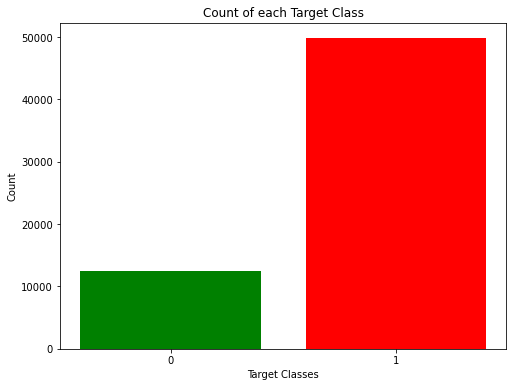

In [5]:
rcParams['figure.figsize'] = 8,6
plt.bar(data['Claim'].unique(), data['Claim'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

In [6]:
# checking for the null values.

data.isnull().sum()

ID                          0
Age                         0
Agency                      0
Agency Type                 0
Commision (in value)        0
Destination                 0
Distribution Channel        0
Duration                    0
Gender                  39575
Net Sales                   0
Product Name                0
Claim                       0
dtype: int64

In [7]:
# Checking the weightage of null values.

(data['Gender'].isnull().sum()/data.shape[0]*100).round(2)

63.54

In [8]:
# Check for unique Value in the DataFrame.

data.nunique()

ID                      50756
Age                        89
Agency                     16
Agency Type                 2
Commision (in value)      940
Destination               102
Distribution Channel        2
Duration                  443
Gender                      2
Net Sales                1037
Product Name               25
Claim                       2
dtype: int64

From the above its clear that more then 60% of the data does not have Gender updated. And we also understand that there are no other features that will help us find out whether the individual is male or female. Thus we will drop this feature

# Pre-processing analysis:

From the above we can say that Agency Type and Distribution Channel which has just 2 unique values and has dataype object we can use One Hot Encoding and convert them.

We will be left with Destination, Agency and Product Name. We will deep dive into this after some analysis of the rest of the data

In [9]:
# Check for the maximum and minimum values to see if there are any invalid.

data.describe()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
count,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000
mean,32844.953458,39.666324,12.829703,60.958804,50.717064,0.200006
std,18065.417216,14.014652,23.498745,114.325330,63.166715,0.400008
min,0.000000,0.000000,0.000000,-2.000000,-389.000000,0.000000
25%,17579.000000,33.000000,0.000000,10.000000,20.000000,0.000000
50%,33446.500000,36.000000,1.880000,25.000000,29.700000,0.000000
75%,48532.250000,43.000000,14.440000,59.000000,58.000000,0.000000
max,63323.000000,118.000000,262.760000,4881.000000,682.000000,1.000000




    Age:
        minimum: 0 which is possible.
        maximum: 118, Way too old to travel.

Lets check what insurance companies say.

Insurance Companies do not give insurance over an age of 85. However there are few who provide insurance upto age of 99. So giving benefit of doubt to our Safe Travel Insurance travel company we will assume that any individual upto age 99 is valid anything above that needs to be treated.

    Commission: The data for commission looks valid.

    Duration:
        minimum: -2
        maximum: 4881

so now lets see what insurance companies say.

- Duration can never be -ve. so this deffinately has to be computed.
- Duration of 4881. 

Insurance companies do not give insurance over 120 days in India. Lets assume that there is an Annual plan in place then we can say that the maximum tenure of a insurance plan would be 365 days. Also given a fact that one can book a ticket 1 year in advance so we will say that the maximum duration of the insurance cannot be more than

    731 days(365 + 366 days considering if it is a leap year)

Incase the values are less then 0.05 we will go ahead and drop the data points else we will have to treat them.

    Net Sales: Minimum has negative values. To check whether sales can be negative or not lets understand how Net Sales is computed.

    Net Sales = The Value for which the insurance is sold - Any expenses incurred/Claim Amount paid
        So it is possible that the Sales is showing negative if the Claim amount is paid, it can also be negative even if the claim ammount is not paid incases where the insurance was sent for claim and got rejected. Now the expenses incurred for doing investigation of that claim would be more than the actual policy amount paid.



In [10]:
# Calculate % of negative Duration Travels

(data['Duration'] < 0).sum()/data.shape[0]*100

0.006421782686873876

In [11]:
(data['Duration'] > 731).sum()/data.shape[0]*100

0.020870793732340097

In [12]:
# Now check the weightage of Age
(data['Age'] > 99).sum()/data.shape[0]*100

1.4497174415617775



Since the weightage is more than 0.05 we will not be deleting these data, we will instead compute age above 118 as 99 we will not be computing this with median or mean since that would manipluate the data. Thus giving the benefit of doubt to the data we will make it 99


In [13]:
# define a function to make age groups as children, adults and senior

def age_convert(age):
    result = ''
    if(age <= 21):
        result = 'Child'
    elif(age <= 50):
        result = 'Adult'
    else:
        result = 'Senior'
    return result

In [14]:
# Write a function for data preprocessing

def data_pre_processing(df):
    # Add a new column in the Database as Age Group

    df['Age Group'] = df['Age'].map(lambda x: age_convert(x))

    # Dropping Feature Gender
    df.drop('Gender',axis =1, inplace=True)
    
    # Since the minimum duration that any travel can have is 1 day thus we impute it by the column median.
    df['Duration'][df['Duration'] < 0] = df['Duration'].median()

    # As we observed duration of any travel cannot be more than 731 we will impute it as 731.
    df['Duration'][df['Duration'] > 731] = 731
    
    # replacing the values that is greater than 99 with the mean of Senior Age
    df['Age'][df['Age'] > 99] = df[df['Age Group'] == 'Senior']['Age'].mean()

In [15]:
data_pre_processing(data)

<ipython-input-14-971bd1b584a6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Duration'][df['Duration'] < 0] = df['Duration'].median()
<ipython-input-14-971bd1b584a6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Duration'][df['Duration'] > 731] = 731
<ipython-input-14-971bd1b584a6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'][df['Age'] > 99] = df[df['Age Group'] == 'Senior']['Age'].mean()


In [16]:
data.describe()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
count,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000
mean,32844.953458,38.904537,12.829703,60.182748,50.717064,0.200006
std,18065.417216,10.794050,23.498745,94.270276,63.166715,0.400008
min,0.000000,0.000000,0.000000,0.000000,-389.000000,0.000000
25%,17579.000000,33.000000,0.000000,10.000000,20.000000,0.000000
50%,33446.500000,36.000000,1.880000,25.000000,29.700000,0.000000
75%,48532.250000,43.000000,14.440000,59.000000,58.000000,0.000000
max,63323.000000,88.000000,262.760000,731.000000,682.000000,1.000000


# EXPLORATORY DATA ANALYSIS.

In [17]:
# Creating a dataframe dropping the features with datatype Object

travel_plot = data.drop(['ID','Agency','Agency Type','Destination','Distribution Channel','Product Name','Claim'], axis = 1)

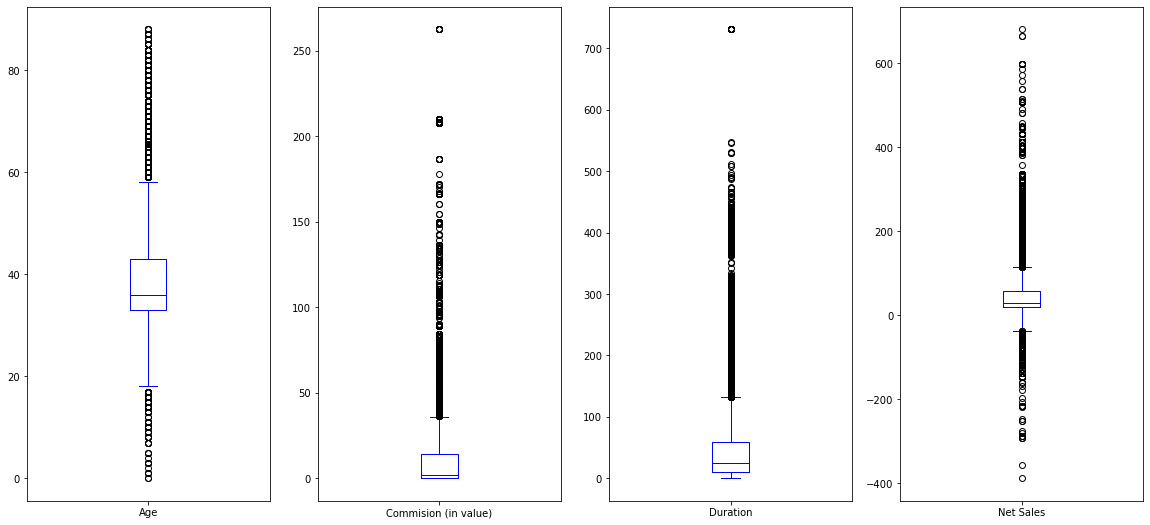

In [18]:
# box and whisker plots

travel_plot.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(20,20),color='blue')
plt.show()

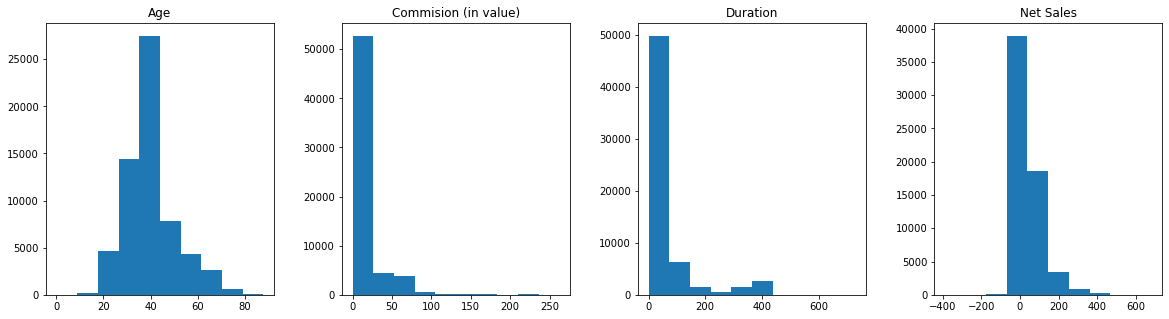

In [19]:
travel_plot.hist(grid=False,sharex=False,sharey=False,figsize=(20,5),layout=(1,4))
plt.show()



We would not be correcting the skewness as the data is valid and whenever in the future if we are getting some 5 to 10 data we wont be able to find skeness there. Thus we will leave it as it is.


## Agencies with maximum claims.

In [20]:
# Finding the Agencies with the Maximum Claims

Claim_mean = (data.groupby('Agency', as_index=False)['Claim'].mean()).nlargest(10,'Claim')
Claim_mean

,Agency,Claim
2,C2B,0.544827
11,LWC,0.467347
15,TTW,0.376923
10,KML,0.301124
4,CCR,0.222749
5,CSR,0.173333
6,CWT,0.145802
3,CBH,0.141414
13,SSI,0.104813
7,EPX,0.084498


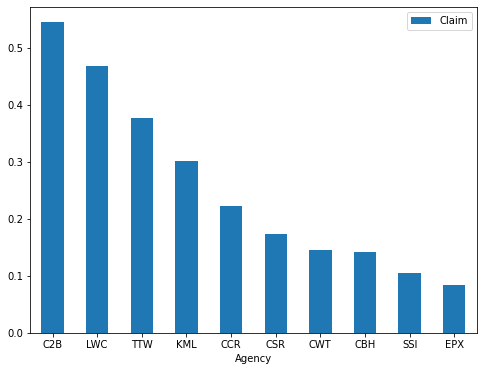

In [21]:
ax = Claim_mean.plot.bar(x='Agency', y='Claim', rot=0)

## Agencies with the most number of net sales.

In [22]:
netsales_mean = (data.groupby('Agency', as_index=False)['Net Sales'].mean()).nlargest(10,'Net Sales')
netsales_mean

,Agency,Net Sales
11,LWC,126.991327
2,C2B,98.088149
15,TTW,93.300000
0,ADM,56.184615
8,JWT,54.912363
10,KML,52.424719
6,CWT,47.191742
7,EPX,33.668716
9,JZI,32.747784
5,CSR,31.706667


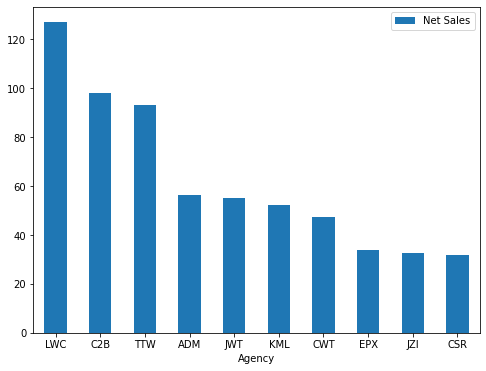

In [23]:
ax1 = netsales_mean.plot.bar(x='Agency', y='Net Sales', rot=0)

Agency      
Claim              0     1
Agency Type               
Airlines       13481  7991
Travel Agency  36349  4467

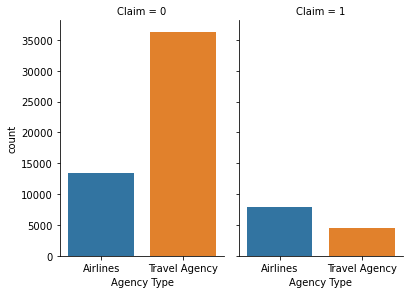

In [24]:
plot2 = sns.catplot(x="Agency Type", col="Claim",data=data, kind="count",height=4, aspect=.7)
data.pivot_table(index=['Agency Type'],columns=['Claim'], values=['Agency'], aggfunc='count')

In [25]:


data.pivot_table(index = ['Product Name'], values = ['Net Sales'], aggfunc = 'mean')



,Net Sales
Product Name,
1 way Comprehensive Plan,27.901674
2 way Comprehensive Plan,44.147544
24 Protect,20.976425
Annual Gold Plan,343.186493
Annual Silver Plan,229.306389
Annual Travel Protect Gold,251.299495
Annual Travel Protect Platinum,328.202632
Annual Travel Protect Silver,206.034766
Basic Plan,26.449732


In [26]:
data.pivot_table(index = ['Age Group'], values = ['Net Sales'], aggfunc = 'count')

,Net Sales
Age Group,
Adult,52582
Child,828
Senior,8878


In [27]:
data.groupby('Age Group')['Claim'].value_counts()

Age Group  Claim
Adult      0        42203
           1        10379
Child      0          605
           1          223
Senior     0         7022
           1         1856
Name: Claim, dtype: int64

/Users/aliluabk/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 288x288 with 0 Axes>

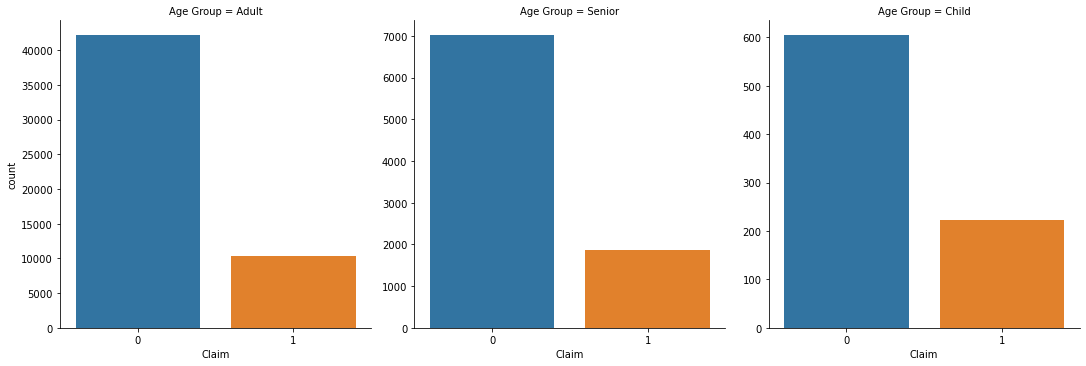

In [28]:
fig = plt.figure(figsize = (4,4))
sns.catplot('Claim', col = 'Age Group', data = data, col_wrap =3, kind='count',sharey=False)

In [29]:
# Converting all IDs to sensible numbers (Risk of default - inspired by WOE)
data['Destination_risk'] = data.groupby('Destination')['Claim'].transform('mean')

In [30]:


def Coutry_Categories(value):
    result = ''
    if(value >= 0.3):
        result = '(1) High Risk - More than 30% Claimed'
    elif(value >= 0.2):
        result = '(2) Medium Risk - More than 20% Claimed'
    elif(value > 0):
        result = '(3) Low Risk - More than 1% Claimed'
    else:
        result = '(4) No Risk Countries'
    return result



In [31]:
data['Risk of Countries'] = data['Destination_risk'].map(lambda x: Coutry_Categories(x))

In [32]:
data.head(5)

,ID,Age,Agency,Agency Type,Commision (in value),Destination,...,Net Sales,Product Name,Claim,Age Group,Destination_risk,Risk of Countries
0,45341,28.0,C2B,Airlines,28.13,SINGAPORE,...,112.5,Silver Plan,1,Adult,0.427905,(1) High Risk - More than 30% Claimed
1,12958,37.0,JZI,Airlines,12.95,PHILIPPINES,...,37.0,Basic Plan,0,Adult,0.052657,(3) Low Risk - More than 1% Claimed
2,18233,27.0,EPX,Travel Agency,0.00,UNITED STATES,...,13.0,Cancellation Plan,0,Adult,0.206539,(2) Medium Risk - More than 20% Claimed
3,31742,36.0,EPX,Travel Agency,0.00,SAUDI ARABIA,...,34.0,Cancellation Plan,0,Adult,0.000000,(4) No Risk Countries
4,14381,26.0,CWT,Travel Agency,23.76,THAILAND,...,39.6,Rental Vehicle Excess Insurance,0,Adult,0.091330,(3) Low Risk - More than 1% Claimed


# Feature Engineering

In [33]:
data.head(1)

,ID,Age,Agency,Agency Type,Commision (in value),Destination,...,Net Sales,Product Name,Claim,Age Group,Destination_risk,Risk of Countries
0,45341,28.0,C2B,Airlines,28.13,SINGAPORE,...,112.5,Silver Plan,1,Adult,0.427905,(1) High Risk - More than 30% Claimed


In [34]:
def feature_processing(df):
    # Converting all categorical columns into numeric using frequency encoding, label encoding and one-hot encoding.
    fe = df.groupby('Destination').size()/len(df)
    df.loc[:,'Dest_fe'] = df['Destination'].map(fe)
    fe_1 = df.groupby('Agency').size()/len(df)
    df.loc[:,'Agency_fe'] = df['Agency'].map(fe_1)
    fe_2 = df.groupby('Product Name').size()/len(df)    
    df.loc[:,'Product Name_fe'] = df['Product Name'].map(fe_2)
    df.drop(columns='Agency',axis=1,inplace=True)
    df.drop(columns='Destination',axis=1,inplace=True)
    df.drop(columns='Product Name',axis=1,inplace=True)
    df.drop(columns='Age Group',axis=1,inplace=True)
    df = pd.get_dummies(df, columns=['Agency Type','Distribution Channel'], drop_first=True)

In [35]:
feature_processing(data)

In [36]:
data.head(5)

,ID,Age,Agency Type,Commision (in value),Distribution Channel,Duration,...,Claim,Destination_risk,Risk of Countries,Dest_fe,Agency_fe,Product Name_fe
0,45341,28.0,Airlines,28.13,Online,34,...,1,0.427905,(1) High Risk - More than 30% Claimed,0.285705,0.218469,0.058535
1,12958,37.0,Airlines,12.95,Online,53,...,0,0.052657,(3) Low Risk - More than 1% Claimed,0.032928,0.086951,0.074894
2,18233,27.0,Travel Agency,0.00,Online,28,...,0,0.206539,(2) Medium Risk - More than 20% Claimed,0.040265,0.488296,0.246500
3,31742,36.0,Travel Agency,0.00,Online,1,...,0,0.000000,(4) No Risk Countries,0.000819,0.488296,0.246500
4,14381,26.0,Travel Agency,23.76,Online,33,...,0,0.091330,(3) Low Risk - More than 1% Claimed,0.083146,0.127729,0.127729


In [37]:
data.drop(columns=['Risk of Countries'],axis=1,inplace=True)

In [38]:
data.drop(columns=['Destination_risk'],axis=1,inplace=True)

In [39]:
data = pd.get_dummies(data, columns=['Agency Type','Distribution Channel'], drop_first=True)

In [40]:
data.head(5)

,ID,Age,Commision (in value),Duration,Net Sales,Claim,Dest_fe,Agency_fe,Product Name_fe,Agency Type_Travel Agency,Distribution Channel_Online
0,45341,28.0,28.13,34,112.5,1,0.285705,0.218469,0.058535,0,1
1,12958,37.0,12.95,53,37.0,0,0.032928,0.086951,0.074894,0,1
2,18233,27.0,0.00,28,13.0,0,0.040265,0.488296,0.246500,1,1
3,31742,36.0,0.00,1,34.0,0,0.000819,0.488296,0.246500,1,1
4,14381,26.0,23.76,33,39.6,0,0.083146,0.127729,0.127729,1,1


# Preparing and training a baseline model.

In [41]:
X = data.drop('Claim', axis = 1)
Y = data['Claim']

In [42]:
# Multi colinearity detection
def plot_heatmap(df, fig_size=(10, 7)):
    fig = plt.figure(figsize=fig_size)
    sns.heatmap(df.corr(), annot=True)
    plt.title('Heatmap for detecting multicollinearity', fontsize=16, color='navy')
    plt.show()

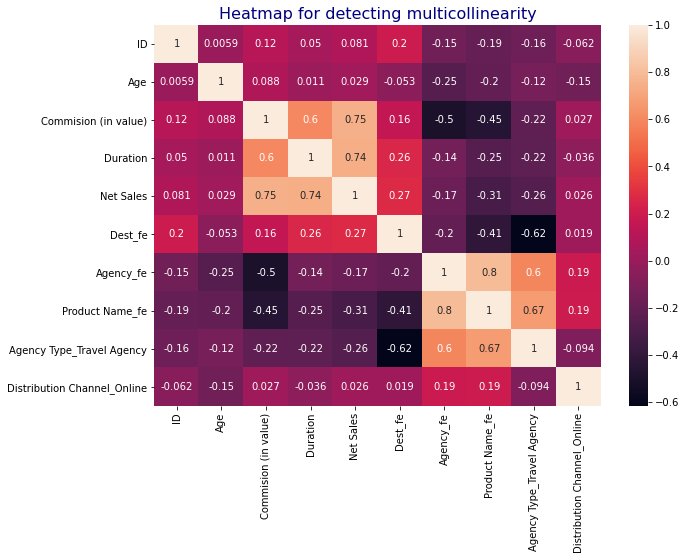

In [43]:
plot_heatmap(X)


Inference :

From the above heat-map we can see that there is not a high co-relation between any features and hence we can continue with all of the above features to train our model.


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7, random_state = 7)

# Model (variety, complexity, tunning): 

# Random Forest Classifier

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)
cm_rf = pd.DataFrame(confusion_matrix(Y_test, y_pred_rf).T, index=rf.classes_,
                     columns=rf.classes_)
cm_rf.index.name = 'Predicted'
cm_rf.columns.name = 'True'
print(cm_rf)
print(accuracy_score(Y_test, y_pred_rf))
print(classification_report(Y_test, y_pred_rf))

True           0     1
Predicted             
0          14868     0
1            104  3715
0.994434633702574
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14972
           1       0.97      1.00      0.99      3715

    accuracy                           0.99     18687
   macro avg       0.99      1.00      0.99     18687
weighted avg       0.99      0.99      0.99     18687



# Hyperparameter tuning for RFC

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV

#this is the classifier used for feature selection
clf_featr_sele = RandomForestClassifier(n_estimators=30, random_state=42, class_weight="balanced") 
rfecv = RFECV(estimator=clf_featr_sele, step=1, cv=5, scoring = 'roc_auc')

#you can have different classifier for your final classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42,class_weight="balanced", max_features = 2) 
CV_rfc = GridSearchCV(clf, param_grid={'max_depth':[2,3]}, cv= 5, refit='AUC', return_train_score=True, verbose=3)

pipeline  = Pipeline([('feature_sele',rfecv),('clf_cv',CV_rfc)], verbose=3)

pipeline.fit(X_train, Y_train)

[Pipeline] ...... (step 1 of 2) Processing feature_sele, total=  50.4s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...max_depth=2;, score=(train=0.804, test=0.807) total time=   0.4s
[CV 2/5] END ...max_depth=2;, score=(train=0.810, test=0.802) total time=   0.4s
[CV 3/5] END ...max_depth=2;, score=(train=0.808, test=0.807) total time=   0.4s
[CV 4/5] END ...max_depth=2;, score=(train=0.804, test=0.801) total time=   0.4s
[CV 5/5] END ...max_depth=2;, score=(train=0.798, test=0.802) total time=   0.4s
[CV 1/5] END ...max_depth=3;, score=(train=0.813, test=0.816) total time=   0.4s
[CV 2/5] END ...max_depth=3;, score=(train=0.817, test=0.810) total time=   0.4s
[CV 3/5] END ...max_depth=3;, score=(train=0.818, test=0.817) total time=   0.4s
[CV 4/5] END ...max_depth=3;, score=(train=0.816, test=0.816) total time=   0.4s
[CV 5/5] END ...max_depth=3;, score=(train=0.813, test=0.817) total time=   0.4s
[Pipeline] ............ (step 2 of 2) Processing clf_cv, to

Pipeline(steps=[('feature_sele',
                 RFECV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        n_estimators=30,
                                                        random_state=42),
                       scoring='roc_auc')),
                ('clf_cv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(class_weight='balanced',
                                                               max_features=2,
                                                               n_estimators=50,
                                                               random_state=42),
                              param_grid={'max_depth': [2, 3]}, refit='AUC',
                              return_train_score=True, verbose=3))],
         verbose=3)

In [47]:
print("Tuned Hyperparameters :", CV_rfc.best_params_)
print("Accuracy :",CV_rfc.best_score_)

Tuned Hyperparameters : {'max_depth': 3}
Accuracy : 0.8150959668163633


# Logistic Regression

In [48]:
logr = LogisticRegression()
logr.fit(X_train,Y_train)
y_pred_logr = logr.predict(X_test)
cm_lg = pd.DataFrame(confusion_matrix(Y_test, y_pred_logr).T, index=logr.classes_,
                     columns=logr.classes_)
cm_lg.index.name = 'Predicted'
cm_lg.columns.name = 'True'
print(cm_lg)

print('\nAccuracy :',accuracy_score(Y_test, y_pred_logr))
print(classification_report(Y_test, y_pred_logr))

True           0     1
Predicted             
0          14562  3002
1            410   713

Accuracy : 0.8174131749344464
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     14972
           1       0.63      0.19      0.29      3715

    accuracy                           0.82     18687
   macro avg       0.73      0.58      0.59     18687
weighted avg       0.79      0.82      0.78     18687



# Hyperparameter tuning for LR

In [49]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [50]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds 

In [51]:
clf.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [52]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :", clf.best_score_)

Tuned Hyperparameters : {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.8250727307725482


In [53]:
logreg = LogisticRegression(C = 0.001, 
                            penalty = 'l1', 
                            solver = 'liblinear')
logreg.fit(X_train,Y_train)
y_pred = logreg.predict(X_test)

print("Accuracy:",logreg.score(X_test, Y_test))

Accuracy: 0.8235136726066249


# Decision Tree Classifier

In [54]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
y_pred_dtc = dtc.predict(X_test)

cm_dtc = pd.DataFrame(confusion_matrix(Y_test, y_pred_dtc).T, index=dtc.classes_,
                     columns=dtc.classes_)
cm_dtc.index.name = 'Predicted'
cm_dtc.columns.name = 'True'

print(cm_dtc)
print('\nAccuracy :', accuracy_score(Y_test, y_pred_dtc))
print(classification_report(Y_test, y_pred_dtc))

True           0     1
Predicted             
0          14582     0
1            390  3715

Accuracy : 0.9791298763846524
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     14972
           1       0.90      1.00      0.95      3715

    accuracy                           0.98     18687
   macro avg       0.95      0.99      0.97     18687
weighted avg       0.98      0.98      0.98     18687



# Hyperparameter tuning for Decision Tree

In [55]:
parameters = dict(criterion=['gini','entropy'],max_depth=np.arange(4,13),
                       min_samples_leaf=np.arange(2,6), min_samples_split=np.arange(2,6),
                       max_features=['auto','sqrt','log2'])

hyp_dtc = GridSearchCV(dtc, parameters, scoring='accuracy', cv=5)
hyp_dtc.fit(X_train, Y_train)

pred_dtc = hyp_dtc.predict(X_test)

print('\nAccuracy :',accuracy_score(Y_test, pred_dtc))
print('\n',classification_report(Y_test, pred_dtc))


Accuracy : 0.8771338363568256

               precision    recall  f1-score   support

           0       0.92      0.93      0.92     14972
           1       0.71      0.65      0.68      3715

    accuracy                           0.88     18687
   macro avg       0.81      0.79      0.80     18687
weighted avg       0.87      0.88      0.88     18687



In [56]:
hyp_dtc.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 3}

# Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
y_pred_gnb = gnb.predict(X_test)

cm_gnb = pd.DataFrame(confusion_matrix(Y_test, y_pred_gnb).T, index=gnb.classes_,
                     columns=gnb.classes_)
cm_gnb.index.name = 'Predicted'
cm_gnb.columns.name = 'True'
print(cm_gnb)
print(accuracy_score(Y_test, y_pred_gnb))
print(classification_report(Y_test, y_pred_gnb))

True           0     1
Predicted             
0          14170  2751
1            802   964
0.8098678225504361
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     14972
           1       0.55      0.26      0.35      3715

    accuracy                           0.81     18687
   macro avg       0.69      0.60      0.62     18687
weighted avg       0.78      0.81      0.78     18687



# Hyperparameter tuning for Naive Bayes

In [58]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold
cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=999)
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=gnb, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(Data_transformed, Y_test);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [59]:
print("Tuned Hyperparameters :", gs_NB.best_params_)
print("Accuracy :",gs_NB.best_score_)

Tuned Hyperparameters : {'var_smoothing': 1.0}
Accuracy : 0.8249228059329294


# K-Nearest Neighbour (KNN)

In [60]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
y_pred_knn = knn.predict(X_test)

cm_knn = pd.DataFrame(confusion_matrix(Y_test, y_pred_knn).T, index=knn.classes_,
                     columns=knn.classes_)
cm_knn.index.name = 'Predicted'
cm_knn.columns.name = 'True'
print(cm_knn)
print(accuracy_score(Y_test, y_pred_knn))
print(classification_report(Y_test, y_pred_knn))

True           0     1
Predicted             
0          13979    22
1            993  3693
0.945684165462621
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     14972
           1       0.79      0.99      0.88      3715

    accuracy                           0.95     18687
   macro avg       0.89      0.96      0.92     18687
weighted avg       0.96      0.95      0.95     18687



# Hyperparameter tuning for KNN

In [61]:
from sklearn.model_selection import GridSearchCV
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [62]:
print("Best Score:" + str(knn_gscv.best_score_)) 
print("Best Parameters: " + str(knn_gscv.best_params_))

Best Score:0.9834157593307363
Best Parameters: {'n_neighbors': 1}


# Support Vector Classifier (SVC)

In [63]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, Y_train)
y_pred_svc = svc.predict(X_test)

cm_svc = pd.DataFrame(confusion_matrix(Y_test, y_pred_svc).T, index=svc.classes_,
                     columns=svc.classes_)
cm_svc.index.name = 'Predicted'
cm_svc.columns.name = 'True'
print(cm_svc)
print(accuracy_score(Y_test, y_pred_svc))
print(classification_report(Y_test, y_pred_svc))

True           0     1
Predicted             
0          14972  3715
1              0     0
0.8011986942794456
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     14972
           1       0.00      0.00      0.00      3715

    accuracy                           0.80     18687
   macro avg       0.40      0.50      0.44     18687
weighted avg       0.64      0.80      0.71     18687



# Hyperparameter tuning for SVC

In [64]:
#param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}

In [65]:
#grid = GridSearchCV(svc,param_grid,refit=True,verbose=3)
#grid.fit(X_train,y_train)

In [66]:
#print(grid.best_estimator_)

In [67]:
models = [['Random Forest Classifier', accuracy_score(Y_test, y_pred_rf)],['Decision Tree', accuracy_score(Y_test, y_pred_dtc)],
           ['Logistic Regression', logreg.score(X_test, Y_test)], 
           ['Naive Bayes', accuracy_score(Y_test, y_pred_gnb)], 
           ['KNN', accuracy_score(Y_test, y_pred_knn)], ['SVC',accuracy_score(Y_test, y_pred_svc)]]

df = pd.DataFrame(models, columns=['Model', 'Accuracy score'])
df = df.sort_values(by='Accuracy score', ascending=False)
df

,Model,Accuracy score
0,Random Forest Classifier,0.994435
1,Decision Tree,0.979130
4,KNN,0.945684
2,Logistic Regression,0.823514
3,Naive Bayes,0.809868
5,SVC,0.801199


In [68]:
tun_models = [['Random Forest Classifier',CV_rfc.best_score_],['Decision Tree', accuracy_score(Y_test, pred_dtc)],
           ['Logistic Regression', clf.best_score_], 
           ['Naive Bayes', gs_NB.best_score_], 
           ['KNN', knn_gscv.best_score_], ['SVC',accuracy_score(Y_test, y_pred_svc)]]

df = pd.DataFrame(tun_models, columns=['Model after tuning', 'Accuracy score'])
df = df.sort_values(by='Accuracy score', ascending=False)
df

,Model after tuning,Accuracy score
4,KNN,0.983416
1,Decision Tree,0.877134
2,Logistic Regression,0.825073
3,Naive Bayes,0.824923
0,Random Forest Classifier,0.815096
5,SVC,0.801199


# Imbalance

In [69]:
#split between training and test set, default 4:1
X_train1, X_test1, y_train, y_test = train_test_split(X, Y)
X_train1.shape, X_test1.shape, y_train.shape, y_test.shape

((46716, 10), (15572, 10), (46716,), (15572,))

### Observation from SMOTE/PCA

#### We note that using SMOTE on the features affects the results of 2D PCA.

#### We do not expect the classifier to perform well as there appears to be no clear boundary between 'Yes' and 'No' claims.

In [70]:
data["Claim_Target"] = np.where(data["Claim"]=='Yes', 1, 0)
data.head()

,ID,Age,Commision (in value),Duration,Net Sales,Claim,Dest_fe,Agency_fe,Product Name_fe,Agency Type_Travel Agency,Distribution Channel_Online,Claim_Target
0,45341,28.0,28.13,34,112.5,1,0.285705,0.218469,0.058535,0,1,0
1,12958,37.0,12.95,53,37.0,0,0.032928,0.086951,0.074894,0,1,0
2,18233,27.0,0.00,28,13.0,0,0.040265,0.488296,0.246500,1,1,0
3,31742,36.0,0.00,1,34.0,0,0.000819,0.488296,0.246500,1,1,0
4,14381,26.0,23.76,33,39.6,0,0.083146,0.127729,0.127729,1,1,0


In [71]:
#split dataset between features and target
features=['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'ID', 'Claim', 'Dest_fe', 'Agency_fe', 'Product Name_fe', 'Agency Type_Travel Agency', 'Agency Type_Travel Agency', 'Distribution Channel_Online', 'Claim_Target']
target = "Claim_Target"

X = data.loc[:, features]
y = data[target]
X.head()

,Duration,Net Sales,Commision (in value),Age,ID,Claim,...,Agency_fe,Product Name_fe,Agency Type_Travel Agency,Agency Type_Travel Agency,Distribution Channel_Online,Claim_Target
0,34,112.5,28.13,28.0,45341,1,...,0.218469,0.058535,0,0,1,0
1,53,37.0,12.95,37.0,12958,0,...,0.086951,0.074894,0,0,1,0
2,28,13.0,0.00,27.0,18233,0,...,0.488296,0.246500,1,1,1,0
3,1,34.0,0.00,36.0,31742,0,...,0.488296,0.246500,1,1,1,0
4,33,39.6,23.76,26.0,14381,0,...,0.127729,0.127729,1,1,1,0


In [72]:
#check imbalance dataset
data["Claim_Target"].value_counts(dropna=False)

0    62288
Name: Claim_Target, dtype: int64

In [73]:
num_input_features = len(features)
num_input_features

13

### Here is can see the data set is Completely imbalanced.

I have tried below methods to get the best model,

1,OverSampling

2,UnderSampling

3,SMOTE

4,giving Weighted sums

changing models like logistic regression, SVM, DT, Random Forest and Bossting algorithm also.


Fortunately Random Forest with balancing the Class weight according to dataset gave me the best Metrics.

In [74]:
df_numerical=data._get_numeric_data()
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           62288 non-null  int64  
 1   Age                          62288 non-null  float64
 2   Commision (in value)         62288 non-null  float64
 3   Duration                     62288 non-null  int64  
 4   Net Sales                    62288 non-null  float64
 5   Claim                        62288 non-null  int64  
 6   Dest_fe                      62288 non-null  float64
 7   Agency_fe                    62288 non-null  float64
 8   Product Name_fe              62288 non-null  float64
 9   Agency Type_Travel Agency    62288 non-null  uint8  
 10  Distribution Channel_Online  62288 non-null  uint8  
 11  Claim_Target                 62288 non-null  int64  
dtypes: float64(6), int64(4), uint8(2)
memory usage: 4.9 MB


In [75]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
Y = data['Claim']
X=df_numerical
print(X.shape)
print(Y.shape)
# Splitting the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(  
X, Y, test_size = 0.3, random_state = 100, stratify=Y)

clf =  RandomForestClassifier(n_estimators=100,random_state=0,class_weight={0: 1, 1: 98.5})
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print('score on test set:', clf.score(X_test, y_test))
print(metrics.classification_report(y_true=y_test, y_pred=pred))

(62288, 12)
(62288,)
score on test set: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14949
           1       1.00      1.00      1.00      3738

    accuracy                           1.00     18687
   macro avg       1.00      1.00      1.00     18687
weighted avg       1.00      1.00      1.00     18687



<AxesSubplot:>

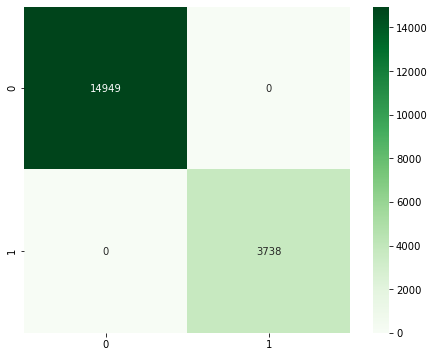

In [76]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test, pred)
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar='True', cmap=plt.cm.Greens)

In [77]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
scores = clf.predict_proba(X_test)
print(scores)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Conclusion

In conclusion, we can say that the use of classification models and data processing and observation of the results that were made during data analysis, we were able to achieve useful ideas. For our project, we use agencies about the destination, the type of agency, the name of the product, the floor. And these data were used for a random forest classifier, hyperparameter settings, logistics regression, classifier of decisions, KNN, imbalance to get the desired results.